# Prednet Straightening Evaluation
Using Kitti test set and Henaff stimuli

In [1]:
import os
import numpy as np
from six.moves import cPickle
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from keras import backend as K
from keras.models import Model, model_from_json
from keras.layers import Input, Dense, Flatten

from prednet import PredNet
from prednet_kitti_utils import SequenceGenerator
import torch
import math

import sys
sys.path.insert(0, '../')

os.environ["CUDA_VISIBLE_DEVICES"]="0"

from Henaff_straightening.utils import *
from prednet_utils import *
%load_ext autoreload

Using TensorFlow backend.
/data/vision/billf/scratch/annekh/miniconda3/envs/tf_19/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/data/vision/billf/scratch/annekh/miniconda3/envs/tf_19/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/data/vision/billf/scratch/annekh/miniconda3/envs/tf_19/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qi

In [2]:
# reload if files are updated
%autoreload 2
from prednet_utils import *
from Henaff_straightening.utils import *

## Gather Curvature Results

In [2]:
train_model = load_prednet_weights()

In [3]:
model_blocks_kitti = get_prednet_blocks(train_model)

R3
R2
R1
R0
prediction


In [4]:
X_test = load_kitti_test(test_path='../../prednet_coxlab/kitti_hkl_py3/X_test.hkl',
                        test_sources='../../prednet_coxlab/kitti_hkl_py3/sources_test.hkl')

In [5]:
kitti_outputs = get_prednet_outputs(X_test, model_blocks_kitti)

0
torch.Size([83, 9, 16, 20, 192])
1
torch.Size([83, 9, 32, 40, 96])
2
torch.Size([83, 9, 64, 80, 48])
3
torch.Size([83, 9, 128, 160, 3])
4
torch.Size([83, 9, 128, 160, 3])


In [6]:
curve_results = {'kitti_test':[None, None]}

curve_results['kitti_test'][0], curve_results['kitti_test'][1] = collect_model_curves(kitti_outputs, 
                                           torch.from_numpy(X_test[:,1:,:,:,:]), use_outputs=True)


In [7]:
model_blocks_Henaff = get_prednet_blocks(train_model, time_steps=11,input_shape=(11, 512, 512, 3))

R3
R2
R1
R0
prediction


In [8]:
Henaff_videos = load_all_henaff_videos('../Henaff_straightening/stimuli/gamma1/')

natural
contrast
artificial


In [9]:
natural_outputs = get_prednet_outputs(Henaff_videos['natural'], model_blocks_Henaff)
contrast_outputs = get_prednet_outputs(Henaff_videos['contrast'], model_blocks_Henaff)
artificial_outputs = get_prednet_outputs(Henaff_videos['artificial'], model_blocks_Henaff)

0
torch.Size([11, 10, 64, 64, 192])
1
torch.Size([11, 10, 128, 128, 96])
2
torch.Size([11, 10, 256, 256, 48])
3
torch.Size([11, 10, 512, 512, 3])
4
torch.Size([11, 10, 512, 512, 3])
0
torch.Size([10, 10, 64, 64, 192])
1
torch.Size([10, 10, 128, 128, 96])
2
torch.Size([10, 10, 256, 256, 48])
3
torch.Size([10, 10, 512, 512, 3])
4
torch.Size([10, 10, 512, 512, 3])
0
torch.Size([11, 10, 64, 64, 192])
1
torch.Size([11, 10, 128, 128, 96])
2
torch.Size([11, 10, 256, 256, 48])
3
torch.Size([11, 10, 512, 512, 3])
4
torch.Size([11, 10, 512, 512, 3])


In [10]:
# curve_results = {}
curve_results['Henaff_natural'] = [None, None]

curve_results['Henaff_natural'][0], curve_results['Henaff_natural'][1] = collect_model_curves(natural_outputs, 
                                           torch.from_numpy(Henaff_videos['natural'][:,1:,:,:,:]), 
                                            use_outputs=True)

curve_results['Henaff_contrast'] = [None, None]

curve_results['Henaff_contrast'][0], curve_results['Henaff_contrast'][1] = collect_model_curves(contrast_outputs, 
                                           torch.from_numpy(Henaff_videos['contrast'][:,1:,:,:,:]), 
                                            use_outputs=True)

curve_results['Henaff_artificial'] = [None, None]

curve_results['Henaff_artificial'][0], curve_results['Henaff_artificial'][1] = collect_model_curves(artificial_outputs, 
                                           torch.from_numpy(Henaff_videos['artificial'][:,1:,:,:,:]), 
                                            use_outputs=True)

In [21]:
full = 0
vid = 9
block = 5
curve_results['Henaff_natural'][full][vid][block]

tensor(77.2163)

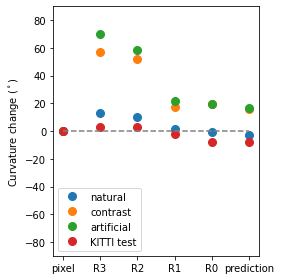

In [11]:
output_dir = 'prednet_prediction_plots'
os.makedirs(output_dir,exist_ok=True)
name = 'Prednet'
xlabels = ['pixel', 'R3', 'R2', 'R1', 'R0', 'prediction']
plt.figure(figsize=(4,4))

plt.plot(xlabels, curve_results['Henaff_natural'][1].mean(0),'o', markersize=8,label='natural')
plt.plot(xlabels, curve_results['Henaff_contrast'][1].mean(0),'o', markersize=8,label='contrast')
plt.plot(xlabels, curve_results['Henaff_artificial'][1].mean(0),'o', markersize=8,label='artificial')
plt.plot(xlabels, curve_results['kitti_test'][1].mean(0),'o', markersize=8,label='KITTI test')

plt.legend(loc='lower left')
plt.plot([xlabels[0], xlabels[-1]],[0,0], '--', color='gray')
plt.ylim([-90, 90])
plt.ylabel('Curvature change ($^\circ$)')
plt.tight_layout()
# plt.savefig(os.path.join(output_dir,f'{name}_curve_change.png'),dpi=300)

Frame visualizations

In [ ]:
# plot {num_vids} video


num_vids = 2

name = 'contrast'
videos = Henaff_videos[name]
outputs = contrast_outputs
nt = 11
save_prediction_plots(num_vids, videos, outputs, output_dir, name, nt)

name = 'artificial'
videos = Henaff_videos[name]
outputs = artificial_outputs
nt=11
save_prediction_plots(num_vids, videos, outputs, output_dir, name, nt)

name = 'natural'
videos = Henaff_videos[name]
outputs = natural_outputs
nt=11
save_prediction_plots(num_vids, videos, outputs, output_dir, name, nt)

name= 'kitti_test'
videos = X_test
outputs = kitti_outputs
nt = 10
save_prediction_plots(num_vids, videos, outputs, output_dir, name, nt)

In [ ]:
make_gif(torch.from_numpy(X_test[0][1:]),name='kitt_test_orig', directory=output_dir)
make_gif(kitti_outputs[-1][0],name='kitt_test_pred', directory=output_dir)

make_gif(torch.from_numpy(Henaff_videos['natural'][5][1:]),name='natural_orig', directory=output_dir)
make_gif(natural_outputs[-1][5],name='natural_pred', directory=output_dir)

make_gif(torch.from_numpy(Henaff_videos['contrast'][9][1:]),name='contrast_orig', directory=output_dir)
make_gif(contrast_outputs[-1][9],name='contrast_pred', directory=output_dir)

make_gif(torch.from_numpy(Henaff_videos['artificial'][5][1:]),name='artificial_orig', directory=output_dir)
make_gif(artificial_outputs[-1][5],name='artificial_pred', directory=output_dir)

## Static Sequence Response
You might need a big gpu is you go up to 500 frames

In [3]:
# make static videos
num_repeats = 500
Henaff_videos = load_all_henaff_videos('../Henaff_straightening/stimuli/gamma1/')
Henaff_videos['repeat'] = np.repeat(Henaff_videos['contrast'][:,0,np.newaxis,:,:,:],num_repeats,1)

natural
contrast
artificial


In [4]:
np.sum(Henaff_videos['repeat'][1,0] - Henaff_videos['repeat'][1,3])

0.0

In [5]:
v = 1
train_model = load_prednet_weights()
model_blocks_Henaff = get_prednet_blocks(train_model, time_steps=num_repeats,input_shape=(num_repeats, 512, 512, 3))
repeat_outputs = get_prednet_outputs(Henaff_videos['repeat'][v:v+1], model_blocks_Henaff, batch_size=1)

R3
R2
R1
R0
prediction
0
torch.Size([1, 499, 64, 64, 192])
1
torch.Size([1, 499, 128, 128, 96])
2
torch.Size([1, 499, 256, 256, 48])
3
torch.Size([1, 499, 512, 512, 3])
4
torch.Size([1, 499, 512, 512, 3])


In [6]:
model_blocks_Henaff_natural = get_prednet_blocks(train_model, time_steps=11,input_shape=(11, 512, 512, 3))
natural_outputs = get_prednet_outputs(Henaff_videos['natural'][v:v+1], model_blocks_Henaff_natural, batch_size=1, omit_first=True)

R3
R2
R1
R0
prediction
0
torch.Size([1, 10, 64, 64, 192])
1
torch.Size([1, 10, 128, 128, 96])
2
torch.Size([1, 10, 256, 256, 48])
3
torch.Size([1, 10, 512, 512, 3])
4
torch.Size([1, 10, 512, 512, 3])


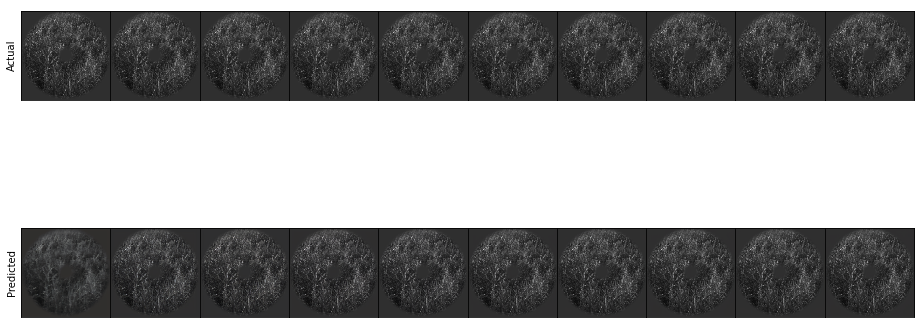

In [8]:
# this is simliar to save_prediction_plots() function in prednet_utils
plt.figure(figsize=(16,8))
nt = 10
gs = gridspec.GridSpec(2, nt)
gs.update(wspace=0., hspace=0.)

for t in range(nt):
    ax = plt.subplot(gs[t])
    plt.imshow(Henaff_videos['repeat'][v,t], interpolation='none')
#     plt.imshow(Henaff_videos['natural'][v,t][1:], interpolation='none')
    plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
    if t==0: plt.ylabel('Actual', fontsize=10)

    plt.subplot(gs[t + nt])
#     plt.imshow(natural_outputs[-1][0, t], interpolation='none')
    plt.imshow(repeat_outputs[-1][0, t], interpolation='none')
    plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
    plt.xticks([])
    plt.yticks([])
    if t==0: plt.ylabel('Predicted', fontsize=10)
        
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig('water_2_frames.png', dpi=300)

In [9]:
Henaff_videos['repeat'].shape

(10, 500, 512, 512, 3)

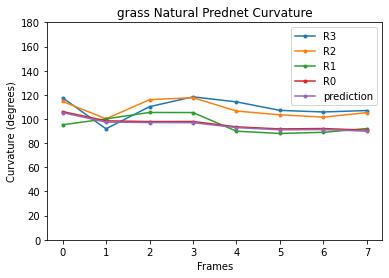

In [18]:
# 
vid_name = 'grass'
block_names=['R3', 'R2', 'R1', 'R0', 'prediction']
for i in range(5):
    plt.plot(computeDistCurv(torch.squeeze(natural_outputs[i]))[1],'.-', label=block_names[i])
plt.ylabel('Curvature (degrees)')
plt.xlabel('Frames')
plt.title(f'{vid_name} Natural Prednet Curvature')
plt.ylim([0,180])
plt.legend()
plt.savefig(f'{vid_name}_natural_prednet_curvature.png',dpi=300)

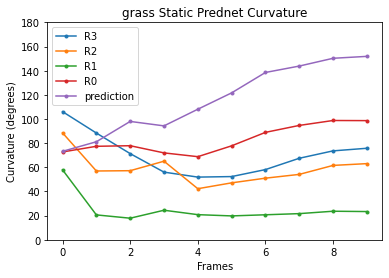

In [19]:
block_names=['R3', 'R2', 'R1', 'R0', 'prediction']
for i in range(5):
    plt.plot(computeDistCurv(torch.squeeze(repeat_outputs[i]))[1][0:10],'.-', label=block_names[i])
plt.ylabel('Curvature (degrees)')
plt.xlabel('Frames')
plt.title(f'{vid_name} Static Prednet Curvature')
plt.ylim([0,180])
plt.legend()
plt.savefig(f'{vid_name}_static_prednet_curvature_10_frame.png',dpi=300)

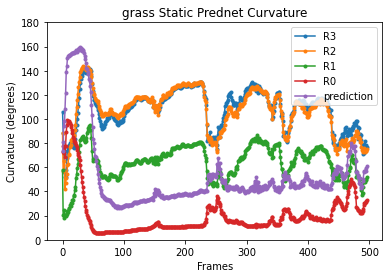

In [21]:
vid_name = 'water_2'
block_names=['R3', 'R2', 'R1', 'R0', 'prediction']
for i in range(5):
    plt.plot(computeDistCurv(torch.squeeze(repeat_outputs[i]))[1],'.-', label=block_names[i])
plt.ylabel('Curvature (degrees)')
plt.xlabel('Frames')
plt.title(f'{vid_name} Static Prednet Curvature')
plt.ylim([0,180])
plt.legend()
plt.savefig(f'{vid_name}_static_prednet_curvature_500_frame.png',dpi=300)

## On/Off

In [2]:
Henaff_videos = load_all_henaff_videos('../Henaff_straightening/stimuli/gamma1/')

natural
contrast
artificial


In [96]:
sample_vid = Henaff_videos['natural'][0]
gray = sample_vid[0,0,0,0]
on_off = np.ones((7*3,512,512,3))*gray
on_off[7:14] = np.repeat(sample_vid[0][np.newaxis,:,:,:],7,0)
print(on_off.shape)

(21, 512, 512, 3)


In [97]:
train_model = load_prednet_weights()
model_blocks_Henaff_E = get_prednet_blocks(train_model, block_names=['E3','E2','E1','E0', 'prediction'], time_steps=7*3,input_shape=(7*3, 512, 512, 3))
on_off_E_outputs = get_prednet_outputs(on_off[np.newaxis,...], model_blocks_Henaff, batch_size=1)

E3
E2
E1
E0
prediction
0
torch.Size([1, 20, 64, 64, 384])
1
torch.Size([1, 20, 128, 128, 192])
2
torch.Size([1, 20, 256, 256, 96])
3
torch.Size([1, 20, 512, 512, 6])
4
torch.Size([1, 20, 512, 512, 3])


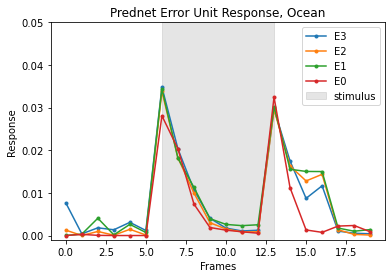

In [100]:
err = torch.mean(on_off_E_outputs[i],axis=(0,2,3)).T

vid_name = 'Ocean'
block_names=['E3','E2','E1','E0', 'prediction']
for i in range(4):
    plt.plot(err[i],'.-', label=block_names[i])
plt.fill_between([6,6,13,13], 0.05, [-0.001]*4, color='gray', alpha=.2,label='stimulus')
plt.ylim([-0.001,0.05])
plt.ylabel('Response')
plt.xlabel('Frames')
plt.title(f'Prednet Error Unit Response, {vid_name}')
plt.legend()
plt.savefig(f'prednet_error_units_{vid_name}.png',dpi=300)

In [101]:
train_model = load_prednet_weights()
model_blocks_Henaff_R = get_prednet_blocks(train_model, block_names=['R3','R2','R1','R0', 'prediction'], time_steps=7*3,input_shape=(7*3, 512, 512, 3))
on_off_R_outputs = get_prednet_outputs(on_off[np.newaxis,...], model_blocks_Henaff, batch_size=1)

R3
R2
R1
R0
prediction
0
torch.Size([1, 20, 64, 64, 384])
1
torch.Size([1, 20, 128, 128, 192])
2
torch.Size([1, 20, 256, 256, 96])
3
torch.Size([1, 20, 512, 512, 6])
4
torch.Size([1, 20, 512, 512, 3])


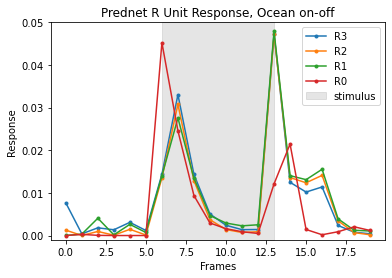

In [103]:
vid_name = 'Ocean'
block_names=['R3','R2','R1','R0', 'prediction']
for i in range(4):
    plt.plot(R[i],'.-', label=block_names[i])
plt.fill_between([6,6,13,13], 0.05, [-0.001]*4, color='gray', alpha=.2,label='stimulus')
plt.ylim([-0.001,0.05])
plt.ylabel('Response')
plt.xlabel('Frames')
plt.title(f'Prednet R Unit Response, {vid_name} on-off')
plt.legend()
plt.savefig(f'prednet_R_units_{vid_name}_onoff.png',dpi=300)

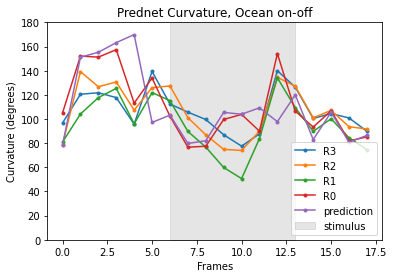

In [104]:
# curvature results
for i in range(5):
    plt.plot(computeDistCurv(torch.squeeze(on_off_R_outputs[i]))[1],'.-', label=block_names[i])
    
plt.fill_between([6,6,13,13], 180, [0]*4, color='gray', alpha=.2,label='stimulus')
plt.ylabel('Curvature (degrees)')
plt.xlabel('Frames')
plt.title(f'Prednet Curvature, {vid_name} on-off')
plt.ylim([0,180])
plt.legend()
plt.savefig(f'prednet_R_curve_{vid_name}_onoff.png',dpi=300)

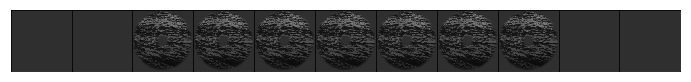

In [105]:
plt.figure(figsize=(12,8))
nt = 11
gs = gridspec.GridSpec(2, nt)
gs.update(wspace=0., hspace=0.)

for t in range(nt):
    ax = plt.subplot(gs[t])
    plt.imshow(on_off[5+t], interpolation='none')
    plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
#     if t==0: plt.ylabel('Actual', fontsize=10)

#     plt.subplot(gs[t + nt])
#     plt.imshow(repeat_outputs[-1][0, t], interpolation='none')
#     plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
#     plt.xticks([])
#     plt.yticks([])
#     if t==0: plt.ylabel('Predicted', fontsize=10)
        
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig('on_off_frames.png', dpi=300)

## TODO: evaluate loss on Henaff stimuli